In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [9]:
df1=df.reset_index()['close']

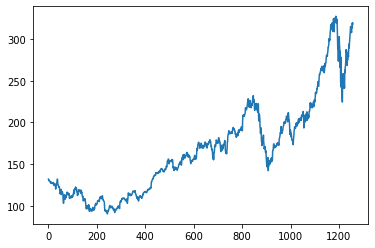

In [10]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
##LSTM are sensitive to the scale of the data. so we apply minmax scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
training_data,test_data=df1[0:training_size, :],df1[training_size: len(df1),: 1]

In [14]:
#convert the array values in dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
  datax, datay=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    datax.append(a)
    datay.append(dataset[i+time_step, 0])
  return numpy.array(datax),numpy.array(datay)


In [19]:
#Splith the data
time_step=100
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step) 

In [20]:
print(X_train.shape),print(X_test.shape),print(y_train.shape),print(y_test.shape)

(716, 100)
(340, 100)
(716,)
(340,)


(None, None, None, None)

In [21]:
## Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 238ms/step - loss: 0.0290 - val_loss: 0.0625
Epoch 2/100
12/12 [==============================] - 2s 166ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 3/100
12/12 [==============================] - 2s 166ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 4/100
12/12 [==============================] - 2s 167ms/step - loss: 8.3940e-04 - val_loss: 0.0041
Epoch 5/100
12/12 [==============================] - 2s 165ms/step - loss: 5.8232e-04 - val_loss: 0.0068
Epoch 6/100
12/12 [==============================] - 2s 164ms/step - loss: 5.9546e-04 - val_loss: 0.0044
Epoch 7/100
12/12 [==============================] - 2s 166ms/step - loss: 5.6604e-04 - val_loss: 0.0042
Epoch 8/100
12/12 [==============================] - 2s 164ms/step - loss: 5.5181e-04 - val_loss: 0.0037
Epoch 9/100
12/12 [==============================] - 2s 162ms/step - loss: 5.7512e-04 - val_loss: 0.0034
Epoch 10/100
12/12 [==============================] - 2s 166ms/step

In [28]:
#Prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [29]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
##Claculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

141.709196423104

In [32]:
## Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))


234.51719040584754

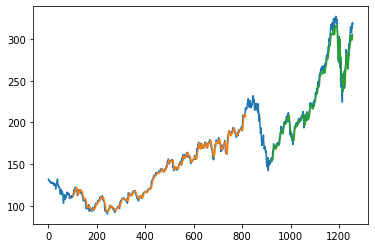

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [41]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<100):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.99016297 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007
 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017
 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113
 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013
 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193
 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292
 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832 0.83049059
 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543 0.78426074
 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843
 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415 0.92793211
 0.948535   0.93333615 0.91746179 0.92544119 0.91771511 0.9483239
 0.94064004 0.96635143 0.9563033  0.96491598 0.92554271 0.91487479
 0.89587343 0.87438905 0.85305071 0.83329713 0.81608951 0.80204213
 0.79144347 0.78428477 0.78030944 0.77906954 0.77998418 0.78239536
 0.78562009 0.7889995  0.79194152 0.7939586  0.7946

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,201)

In [43]:
df3=df1.tolist()
df3.extend(lst_output)

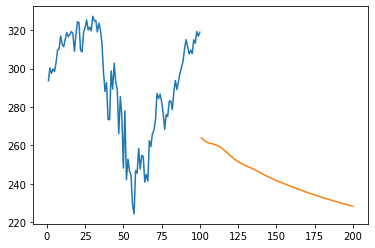

In [44]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

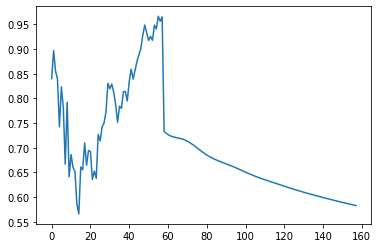

In [45]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

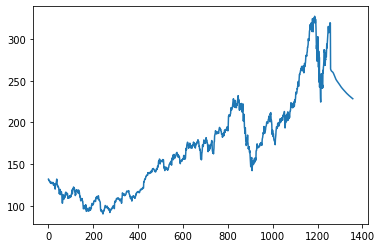

In [46]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
